# Contents <a id='back'></a>

* [1. Introdução](#intro)
* [2. Inicialização](#inicio)
* [3. Carregando dados](#carregamento)
* [4. Pré processamento de dados](#data_processing)
    * [4.1 Renomeando colunas](#colunas)
    * [4.2 Tipo de dados](#tipos)
* [5. Análise exploratória dos dados](#data_analysis)
* [6. Previsão da rotatividade](#previsao)
    * [6.1 Regressão Logística](#regressao)
    * [6.2 Floresta Aleatória](#floresta)
* [7. Agrupamentos](#agrupamento)
* [8. Conclusão](#conclusion)

## Introdução

A rede de academias Model Fitness está desenvolvendo uma estratégia de interação com o cliente baseados em dados analíticos.

Um dos problemas mais comuns que academias e outros serviços enfrentam é a rotatividade de clientes. Como você sabe se um cliente não está mais com você?

Em vez de lutar com a rotatividade, Model Fitness digitalizou uma parte dos perfis dos clientes. Minha tarefa é analisá-los e vir com uma estratégia de retenção de clientes.

## Inicialização

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans

## Carregando dados

In [2]:
data = pd.read_csv('/datasets/gym_churn_us.csv')

## Pré processamento de dados

- `Churn` — a rotatividade do mês em questão

Campos de dados atuais:

Dados do mês anterior
- `gender`
- `Near_Location` — se o cliente morar ou trabalhar na vizinhança onde a academia está localizada
- `Partner` — se o usuário for um funcionário de uma companhia parceira (a academia tem empresas parceiras cujos funcionários conseguem descontos; nesses casos, a academia armazena informações sobre clientes de são funcionários)
- `Promo_friends` — se o cliente originalmente se inscreveu através de uma oferta "traga um amigo" eles normalmente usam o código de promoção do amigo quando pagam pela primeira filiação)
- `Phone` — se o usuário fornece o seu número de telefone
- `age` (idade)
- `Lifetime` — o tempo (em meses) desde a primeira vez que o cliente veio à academia

Dados do log de frequência e compras e dados sobre status de filiação atual
- `Contract_period` — 1 mês, 3 meses, 6 meses, ou um ano
- `Month_to_end_contract` — os meses remanescentes até que o contrato expira
- `Group_visits` — se o cliente participa de sessões em grupo
- `Avg_class_frequency_total` — frequência média de idas por semana por toda a vida do cliente
- `Avg_class_frequency_current_month` — frequência média de visitas por semana durante o mês corrente
- `Avg_additional_charges_total` — a quantidade total de dinheiro gasto em outros serviços da academia: café, artigos esportivos, cosméticos, massagem, etc.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [4]:
data.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [5]:
data.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


In [6]:
data.duplicated().sum()

0

Possui 4000 linhas e 14 colunas
- Não há valores ausentes;
- Não há valores duplicados;
- Vou mudar o nome das colunas para letras minúsculas;
- Vou mudar a coluna `Month_to_end_contract` para o tipo inteiro.

### Renomeando colunas

In [7]:
data.columns = data.columns.str.lower()

In [8]:
# Conferindo se funcionou
data.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

### Tipo de dados

In [9]:
data['month_to_end_contract'] = data['month_to_end_contract'].astype(int)

In [10]:
# Conferindo se funcionou
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   int64  
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

## Análise exploratória dos dados

In [11]:
data.groupby(['churn']).mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


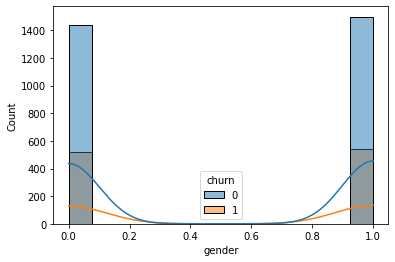

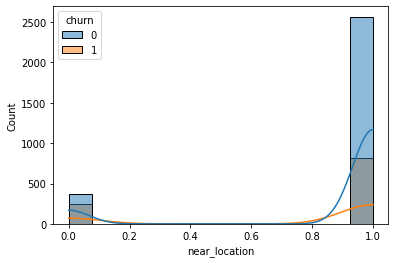

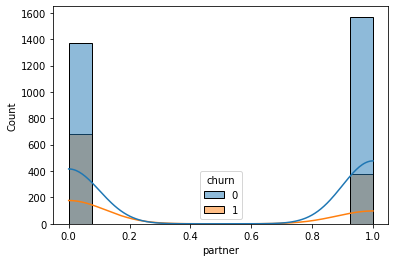

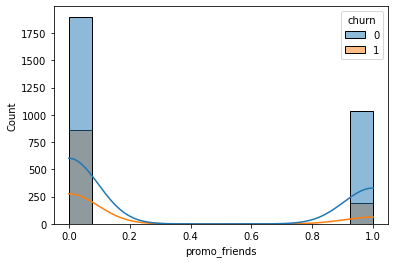

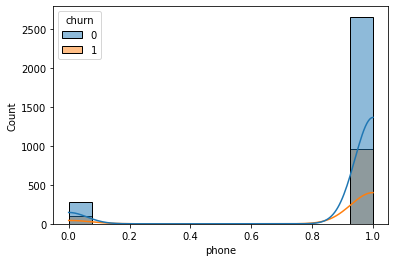

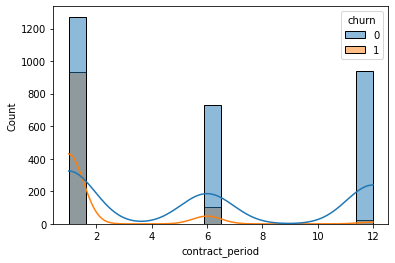

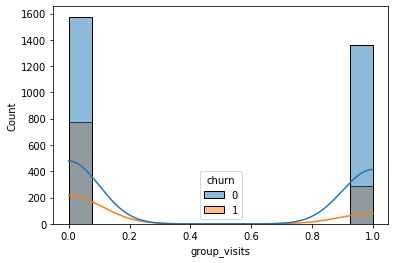

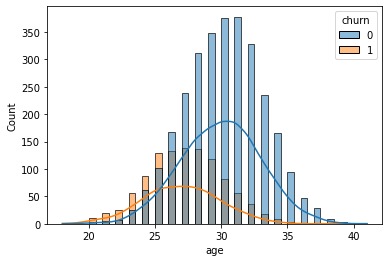

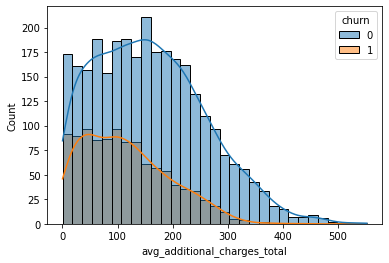

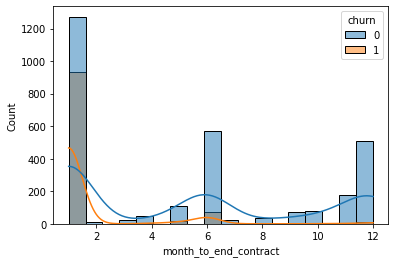

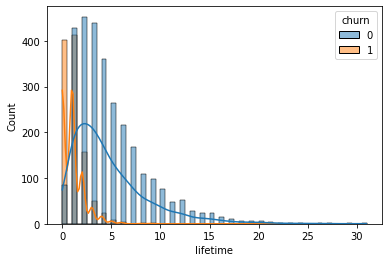

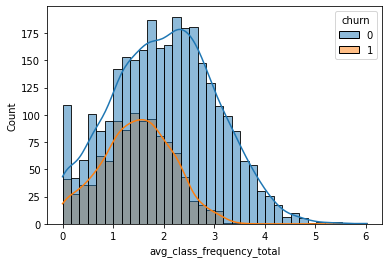

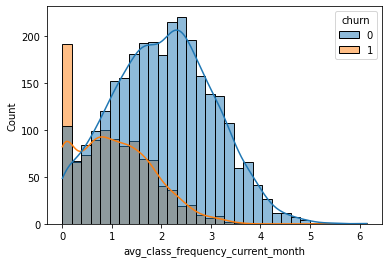

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


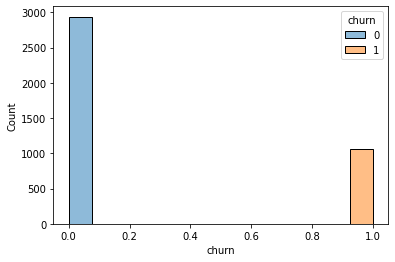

In [12]:
# Construindo histogramas 
for i in data.columns:
    sns.histplot(data=data, x=i, hue='churn', kde=True)
    plt.show()

Os clientes que tem maior tendência de ficar na academia são aqueles que:
- Moram perto da academia
- São de companhia parceira
- Vieram da promoção do código de um amigo
- Tem contratos longos
- Participam de sessões de grupo
- Tem entre 25 e 40 anos
- Restam mais que 1 mês para encerrar o contrato
- Estão a mais de 3 meses frequentando a academia;
- Frequentam mais a academia durante a semana

In [13]:
# Matriz de correlação
corr_df = data.corr()
print("The correlation DataFrame is:")
print(corr_df, '\n')

The correlation DataFrame is:
                                     gender  near_location   partner  \
gender                             1.000000       0.006699 -0.010463   
near_location                      0.006699       1.000000 -0.005119   
partner                           -0.010463      -0.005119  1.000000   
promo_friends                     -0.005033       0.210964  0.451960   
phone                             -0.008542      -0.015763  0.009970   
contract_period                    0.000502       0.150233  0.306166   
group_visits                       0.017879       0.154728  0.022710   
age                                0.013807       0.058358  0.047480   
avg_additional_charges_total      -0.009334       0.040761  0.022941   
month_to_end_contract             -0.001281       0.143961  0.294632   
lifetime                           0.013579       0.070921  0.061229   
avg_class_frequency_total          0.014620       0.043127  0.024938   
avg_class_frequency_current_month 

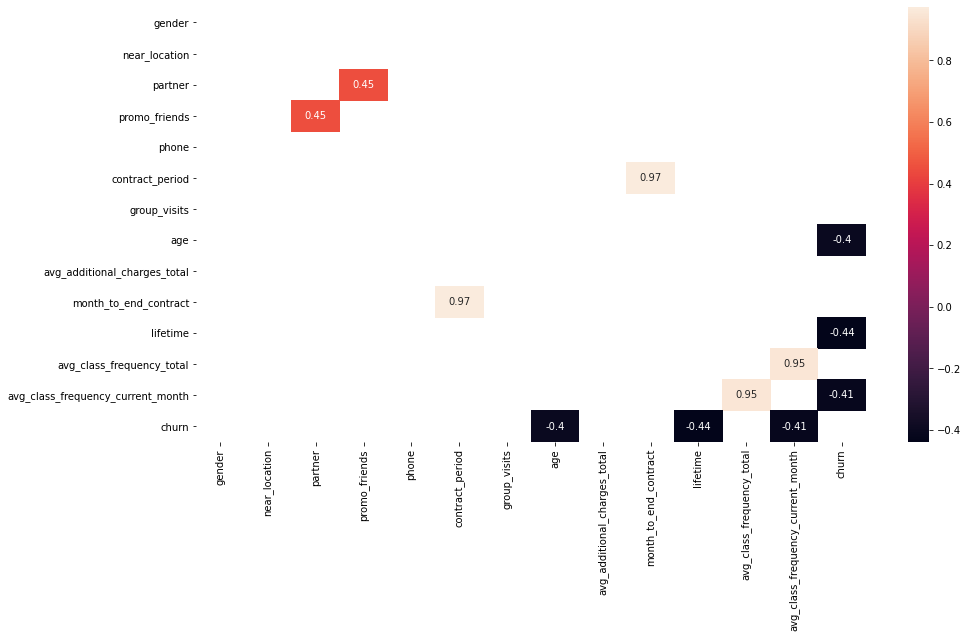

In [14]:
# Considerando o critério de correlação - maiores 0.4 e menores que 1
filtro = (data.corr() > 0.4) & (data.corr() < 1)

# Considerando um 2º filtro menores que -0.4 e maiores que -1
filtro2 = (data.corr() > -1) & (data.corr() < -0.4)

plt.figure(figsize=(15, 8))
sns.heatmap(corr_df[filtro | filtro2], annot=True)
plt.show()

Sobre as correlações:
- A correlação entre o período de contrato e os meses para acabar o contrato é nítida;
- A correlação entre a frequência de idas por semana durante o mês e as idas por semana por toda a vida do cliente também é clara;
- Há uma correlação entre companhia parceira e promoção do código de amigos - talvez as pessoas dessa companhia parceira entrem com o código de pessoas amigas/ colegas de trabalho dessa mesma companhia.
- Há uma correlação negativa entre idade e retorno à academia, pessoas jovens (menos de 40 anos) tendem a ficar mais na academia.

## Predição da rotatividade

In [15]:
# Dividindo os dados em características
X = data.drop('churn', axis=1)
y = data['churn']

In [16]:
# Dividindo dados de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [17]:
# Padronizando os dados
scaler = StandardScaler()
scaler.fit(X_train)
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)


### Regressão Logística

In [18]:
# Definindo modelo
lr_model = LogisticRegression(random_state=0)

In [19]:
# Treinando modelo
lr_model.fit(X_train_st, y_train)

LogisticRegression(random_state=0)

In [20]:
# Usando o modelo treinado para fazer previsões
predictions = lr_model.predict(X_test_st)
probabilities = lr_model.predict_proba(X_test_st)

In [21]:
print('Métricas da regressão logística')
print('Acurácia: {:.2f}'.format(accuracy_score(y_test, predictions)))
print('Precisão: {:.2f}'.format(precision_score(y_test, predictions)))
print('Sensibilidade: {:.2f}'.format(recall_score(y_test, predictions)))
print('F1: {:.2f}'.format(f1_score(y_test, predictions)))
print('ROC_AUC: {:.2f}'.format(roc_auc_score(y_test, predictions)))

Métricas da regressão logística
Acurácia: 0.92
Precisão: 0.85
Sensibilidade: 0.83
F1: 0.84
ROC_AUC: 0.89


### Floresta Aleatória

In [22]:
#Definindo o modelo
rf_model = RandomForestClassifier(random_state=0)

In [23]:
# Treinando modelo
rf_model.fit(X_train_st, y_train)

RandomForestClassifier(random_state=0)

In [24]:
# Usando o modelo treinado para fazer previsões
rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)

In [25]:
print('Métricas da floresta aleatória')
print('Acurácia: {:.2f}'.format(accuracy_score(y_test, rf_predictions)))
print('Precisão: {:.2f}'.format(precision_score(y_test, rf_predictions)))
print('Sensibilidade: {:.2f}'.format(recall_score(y_test, rf_predictions)))
print('F1: {:.2f}'.format(f1_score(y_test, rf_predictions)))
print('ROC_AUC: {:.2f}'.format(roc_auc_score(y_test, rf_predictions)))

Métricas da floresta aleatória
Acurácia: 0.92
Precisão: 0.84
Sensibilidade: 0.81
F1: 0.83
ROC_AUC: 0.88


Os dois modelos são praticamente iguais, mas Regressão Logística rendeu melhores resultados.

## Agrupamentos

In [26]:
X_sc = scaler.fit_transform(X)

linked = linkage(X_sc, method = 'ward')

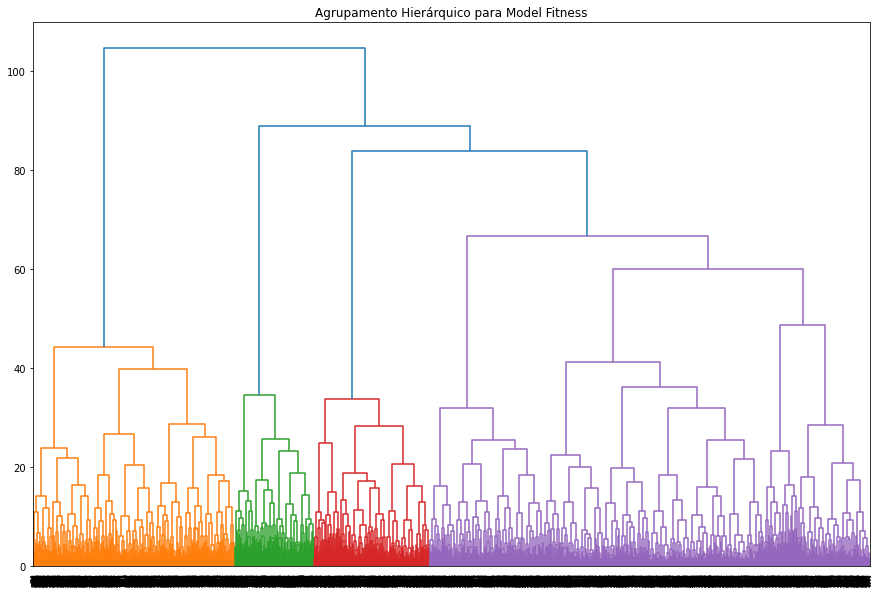

In [27]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Agrupamento Hierárquico para Model Fitness')
plt.show() 

In [28]:
km = KMeans(n_clusters = 5) 

In [29]:
labels = km.fit_predict(X_sc)

data['agrupamento'] = labels

In [30]:
data.groupby(['agrupamento']).mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
agrupamento,,,,,,,,,,,,,,
0,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369,0.267532
1,0.484921,1.000000,0.350794,0.238095,1.000000,1.953968,0.341270,28.167460,131.516081,1.861905,2.431746,1.246646,1.011770,0.515079
2,0.559622,0.976387,0.360094,0.237308,0.998819,2.687131,0.469894,30.109799,161.594478,2.478158,4.890201,2.847678,2.846030,0.067296
3,0.495050,0.000000,0.463366,0.079208,1.000000,2.352475,0.215842,28.477228,135.457501,2.198020,2.809901,1.660461,1.477324,0.443564
4,0.503490,0.959123,0.782652,0.573280,1.000000,10.923230,0.546361,29.991027,160.881742,9.983051,4.748754,1.977676,1.970029,0.027916


**GRUPO 0:**
- Gênero: Há um equilíbrio de gênero
- Proximidade do local: maioria mora perto da academia
- Parceiro: quase metade são de companhias parceiras (47%) 
- Promoção de amigos: poucos se inscreveram através da promoção
- Tefefone: Nenhum forneceu o contato
- Período do contato: contrato com duração média de quase 5 meses
- Sessões em grupo: Quase metade (42%) participa de sessões em grupo
- Idade: Média de 29 anos
- Custo adicional: Média de aproximadamente 144
- Tempo restante do contrato: Média de 4,5 meses
- Tempo de associação: Média de quase 4 meses
- Frequência de aulas por semana: 1,8 vezes na semana
- Frequência de aulas por semana no mês atual: 1,7 vezes na semana
- Taxa de cancelamento: 26% dos membros cancelaram sua associação

**GRUPO 1:**
- Gênero: Há um equilíbrio de gênero
- Proximidade do local: todos moram perto da academia
- Parceiro: Menos de 40% são de companhias parceiras
- Promoção de amigos: poucos se inscreveram através da promoção
- Tefefone: Todos forneceram o contato
- Período do contato: contrato com duração média de quase 2 meses
- Sessões em grupo: Poucos (34%) participam de sessões em grupo
- Idade: Média de 28 anos
- Custo adicional: Média de 131,5
- Tempo restante do contrato: Média de 1,8 meses
- Tempo de associação: Média de 2,4 meses
- Frequência de aulas por semana: 1,2 vezes na semana
- Frequência de aulas por semana no mês atual: 1 vez na semana
- Taxa de cancelamento: Alta taxa, 51% dos membros cancelaram sua associação

**GRUPO 2:**
- Gênero: Há um equilíbrio de gênero
- Proximidade do local: maioria mora perto da academia
- Parceiro: Menos de 40% são de companhias parceiras
- Promoção de amigos: poucos se inscreveram através da promoção
- Tefefone: Quase todos forneceram o contato
- Período do contato: contrato com duração média de quase 3 meses
- Sessões em grupo: Quase metade (47%) participa de sessões em grupo
- Idade: Média de 30 anos
- Custo adicional: Média de 161,5
- Tempo restante do contrato: Média de 2,4 meses
- Tempo de associação: Média de quase 5 meses
- Frequência de aulas por semana: 2,8 vezes na semana
- Frequência de aulas por semana no mês atual: 2,8 vezes na semana
- Taxa de cancelamento: Baixa taxa, 6% dos membros cancelaram sua associação

**GRUPO 3:**
- Gênero: Há um equilíbrio de gênero
- Proximidade do local: nenhum mora perto da academia
- Parceiro: quase metade são de companhias parceiras (46,3%)
- Promoção de amigos: poucos se inscreveram através da promoção
- Tefefone: Todos forneceram o contato
- Período do contato: contrato com duração média de 2 meses
- Sessões em grupo: Poucos (21,5%) participam de sessões em grupo
- Idade: Média de 28 anos
- Custo adicional: Média de 135,45
- Tempo restante do contrato: Média de 2 meses
- Tempo de associação: Média de quase 3 meses
- Frequência de aulas por semana: 1,6 vezes na semana
- Frequência de aulas por semana no mês atual: 1,4 vezes na semana
- Taxa de cancelamento: Alta taxa, 44% dos membros cancelaram sua associação

**GRUPO 4:**
- Gênero: Há um equilíbrio de gênero
- Proximidade do local: maioria mora perto da academia
- Parceiro: grande parte são de companhias parceiras
- Promoção de amigos: mais da metade se inscreveram através da promoção
- Tefefone: Todos forneceram o contato
- Período do contato: contrato com duração média de quase 11 meses
- Sessões em grupo: Mais da metade (54,6%) participa de sessões em grupo
- Idade: Média de 30 anos
- Custo adicional: Média de 160,8
- Tempo restante do contrato: Média de 10 meses
- Tempo de associação: Média de quase 5 meses
- Frequência de aulas por semana: 1,97 vezes na semana
- Frequência de aulas por semana no mês atual: 1,97 vezes na semana
- Taxa de cancelamento: Baixa taxa, quase 3% dos membros cancelaram sua associação


Os grupos 1 e 3 são os mais propensos a sair, enquanto os grupos 2 e 4 possuem baixa taxa de cancelamento - são leais.

## Conclusão

Iniciei importando as bibliotecas pandas, seaborn, matplotlib, sklearn e scipy e carregando a tabela gym churn.

**Em seguida, o pré processamento de dados, onde:**
- Mudei o nome das colunas para letras minúsculas;
- Mudei a coluna Month_to_end_contract para o tipo inteiro.

**Na análise exploratória, chegamos aos insights:**

Os clientes que tem maior tendência de ficar na academia são aqueles que:
- Moram perto da academia
- São de companhia parceira
- Vieram da promoção do código de um amigo
- Tem contratos longos
- Participam de sessões de grupo
- Tem entre 25 e 40 anos
- Restam mais que 1 mês para encerrar o contrato
- Estão a mais de 3 meses frequentando a academia;
- Frequentam mais a academia durante a semana

Sobre as correlações:
- A correlação entre o período de contrato e os meses para acabar o contrato é nítida;
- A correlação entre a frequência de idas por semana durante o mês e as idas por semana por toda a vida do cliente também é clara;
- Há uma correlação entre companhia parceira e promoção do código de amigos - talvez as pessoas dessa companhia parceira entrem com o código de pessoas amigas/ colegas de trabalho dessa mesma companhia.
- Há uma correlação negativa entre idade e retorno à academia, pessoas jovens (menos de 40 anos) tendem a ficar mais na academia.

**Na previsão da rotatividade:**
- Ao usar dois modelos (regressão logística e floresta aleatória), vimos que regressão logística apresentou melhores resultados.

**No agrupamento:**
- Identificamos 5 grupos, sendo o grupo 1 e 3 mais propensos a sair, e os grupos 2 e 4 os mais leais, com baixas taxas de cancelamento.

**Recomendações:**
- Melhorar a experiência do cliente: oferecendo treinos personalizados para cada cliente, suporte, boa infraestrutura (com acessibilidade);
- Oferecer incentivos: promoções e descontos (principalmente para contratos mais longos), programa de fidelidade, prêmios (para aqueles que levarem um amigo, que frequentarem a academia mais vezes na semana, etc), brindes (para aqueles que renovarem o contrato), etc;
- Procurar saber a oponião do cliente: realizar pesquisas de satisfação ajudará a entender a necessidade do cliente para assim melhorar a experiência dele na academia;
- Marketing: foco em pessoas que moram perto/na região da academia e que são jovens (de 25 a 40 anos);
- Sempre monitorar a rotatividade, a fim de prever e resolver o problema antes mesmo dele aparecer.



